# SubReddit Web Scraping, Analysis & Classification: Data Cleaning & Analysis

In this notebook, we read in the CSV files that contain posts from r/homeassistant and r/homeautomation that were extracted in the *Data Collection* notebook.

# Data Cleaning

## Import all necessary libraries

In [1]:
import pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join
import re
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from html import unescape
import emoji # 0.6.0
from nltk.corpus import stopwords as sw
import nltk
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer

## Read in CSV files

In [2]:
# declare subfolder location of csv files
data_subfolder = '../data/'

In [3]:
#read in r/homeassistant data
assist_df = pd.read_csv(join(data_subfolder, 'home_assistant_[t3_juxvds].csv'))
print('Home Assistant dataframe shape: {}'.format(assist_df.shape))

#read in r/homeautomation data
auto_df = pd.read_csv(join(data_subfolder, 'home_automation_[t3_jtk31e].csv'))
print('Home Automation dataframe shape: {}'.format(auto_df.shape))

Home Assistant dataframe shape: (501, 115)
Home Automation dataframe shape: (501, 116)


## Extract columns targeted for analysis

In [4]:
targeted_columns = ['title','selftext','created_utc','stickied','subreddit_name_prefixed','url','is_video']

assist_filtered_df = assist_df.loc[:, targeted_columns]
assist_filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   title                    501 non-null    object 
 1   selftext                 435 non-null    object 
 2   created_utc              501 non-null    float64
 3   stickied                 501 non-null    bool   
 4   subreddit_name_prefixed  501 non-null    object 
 5   url                      501 non-null    object 
 6   is_video                 501 non-null    bool   
dtypes: bool(2), float64(1), object(4)
memory usage: 20.7+ KB


## Check for duplicates

We check for duplicate posts based on the `title` and `selftext` columns:

In [5]:
# check dropped shape
assist_filtered_df = assist_filtered_df.drop_duplicates(subset=['title', 'selftext'])
assist_filtered_df.shape

(501, 7)

Based on above check, no duplicates were detected, i.e. all `title` and `selftext` values were unique.

## Investigate missing values in `selftext` column

Preliminary check on columns revealed some missing values in the `selftext` column. We print out the records to take a closer look:

In [6]:
assist_filtered_df.loc[assist_filtered_df.loc[:,'selftext'].isnull(),:]

title selftext   created_utc  \
3           Moonraker data in Home Assistant revisited      NaN  1.606470e+09   
9    Smart Garage Door Opener | Shelly 1 &amp; Home...      NaN  1.606509e+09   
27                   How to bake a raspberry pi (4) :P      NaN  1.606453e+09   
29   Physical Zigbee Alarm Keypad Integrated into H...      NaN  1.606406e+09   
31        This is why I'm so excited HA works locally.      NaN  1.606415e+09   
..                                                 ...      ...           ...   
476             My new home assistant needs a sticker.      NaN  1.605581e+09   
479                                 Successful Sunday!      NaN  1.605509e+09   
489                Track network data usage by device?      NaN  1.605467e+09   
491  BOM integration gone after updating to 0.117.6...      NaN  1.605530e+09   
499  Prototyping ESP32 PWM LED Controller for Home ...      NaN  1.605452e+09   

     stickied subreddit_name_prefixed  \
3       False         r/homeassistant   
9       False         r/homeassistant   
27      False         r/homeassistant   
29      False         r/homeassistant   
31      False         r/homeassistant   
..        ...                     ...   
476     False         r/homeassistant   
479     False         r/homeassistant   
489     False         r/homeassistant   
491     False         r/homeassistant   
499     False         r/homeassistant   

                                                   url  is_video  
3                  https://i.redd.it/lsh2126u3r161.png     False  
9                         https://youtu.be/rix-sO9hGSc     False  
27                 https://i.redd.it/kcrc4wbzqp161.jpg     False  
29               https://www.reddit.com/gallery/k1hg4w     False  
31   https://eminetra.com.au/people-cant-vacuum-or-...     False  
..                                                 ...       ...  
476                https://i.redd.it/40zzxhkmrpz51.jpg     False  
479                https://i.redd.it/tdnht51csjz51.jpg     False  
489                https://i.redd.it/inq4d2tkbgz51.png     False  
491                https://i.redd.it/9cfucrg2ilz51.jpg     False  
499  https://blog.flicksfix.com/2020/11/14/making-e...     False  

[66 rows x 7 columns]

There are 66 records from r/homeassistant with `selftext` value being missing. We attempt to look into one such posts, located at index 499 as shown in above dataframe ([original post located here](https://www.reddit.com/r/homeassistant/comments/jumz9l/prototyping_esp32_pwm_led_controller_for_home/)):

<img src='../images/homeassistant_title_only.jpg' style="border:1px solid black;" />

It turns out that some posts like the above just consist of only the title and at most another hyperlink to an external resource, as those users decided that it was not unnecessary to share further details in the main post body. We will replace the missing values with empty strings:

In [7]:
assist_filtered_df.loc[:,'selftext'].fillna('', inplace=True)
assist_filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 501 entries, 0 to 500
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   title                    501 non-null    object 
 1   selftext                 501 non-null    object 
 2   created_utc              501 non-null    float64
 3   stickied                 501 non-null    bool   
 4   subreddit_name_prefixed  501 non-null    object 
 5   url                      501 non-null    object 
 6   is_video                 501 non-null    bool   
dtypes: bool(2), float64(1), object(4)
memory usage: 24.5+ KB


## Create datetime column based on `created_utc`

The numerical value in 'created_utc' is actually unix time notation, i.e. number of seconds since 1st January 1970. We will create another column `created_datetime` for containing date/time value in a more useful format:

In [8]:
assist_filtered_df.loc[:,'created_datetime'] = assist_filtered_df.loc[:,'created_utc'] \
                                        .apply(lambda x: datetime.datetime(1970, 1, 1) + datetime.timedelta(seconds=x))

assist_filtered_df.head(5)

title  \
0                   Home Assistant Forums &amp; Chat   
1                                     Ditching Alexa   
2  A Wake Up Lights based on the next phone alarm...   
3         Moonraker data in Home Assistant revisited   
4         Peanut Plug Firmware Upgrade Tutorial -ZHA   

                                            selftext   created_utc  stickied  \
0  All discussion related to Home Assistant and r...  1.462876e+09      True   
1  I’m really getting tired of the Alexa integrat...  1.606537e+09     False   
2  There is another version [A Wake Up Lights](ht...  1.606518e+09     False   
3                                                     1.606470e+09     False   
4  We finally have a way to upgrade Peanut Plugs ...  1.606520e+09     False   

  subreddit_name_prefixed                                                url  \
0         r/homeassistant  https://www.reddit.com/r/homeassistant/comment...   
1         r/homeassistant  https://www.reddit.com/r/homeassistant/comment...   
2         r/homeassistant  https://www.reddit.com/r/homeassistant/comment...   
3         r/homeassistant                https://i.redd.it/lsh2126u3r161.png   
4         r/homeassistant  https://www.reddit.com/r/homeassistant/comment...   

   is_video    created_datetime  
0     False 2016-05-10 10:22:34  
1     False 2020-11-28 04:19:07  
2     False 2020-11-27 22:52:12  
3     False 2020-11-27 09:33:08  
4     False 2020-11-27 23:25:34

## Cleaning character artifacts

The original `title` and `selftext` values from the subreddits are likely to contain various encoded characters that facilitate formatting at the HTML level. When captured during web-scraping, these characters become unencoded, and become artifacts within the text, which need to be cleaned away.

### Process newline characters

Firstly, we replace occurrences of newline characters (`\n` ) with spaces:

In [9]:
assist_filtered_df.loc[:,'title_cleaned'] = assist_filtered_df.loc[:,'title'].apply(lambda s: s.replace('\n', ' '))
assist_filtered_df.loc[:,'selftext_cleaned'] = assist_filtered_df.loc[:,'selftext'].apply(lambda s: s.replace('\n', ' '))

### Process URL strings

There are usually URLs being shared in the subreddits posts itself (users will want to share images to facilitate discussion):

In [10]:
# naive search for URLs embedded in post
post_with_urls = list(assist_filtered_df.loc[assist_filtered_df.loc[:,'selftext_cleaned'].str.contains('http'),'selftext_cleaned'])
print('Number of selftext with URLs within: {}'.format(len(post_with_urls)))
title_with_urls = list(assist_filtered_df.loc[assist_filtered_df.loc[:,'title_cleaned'].str.contains('http'),'title_cleaned'])
print('Number of titles with URLs within: {}'.format(len(title_with_urls)))

Number of selftext with URLs within: 134
Number of titles with URLs within: 0


In [11]:
#assist_filtered_df.loc[assist_filtered_df.loc[:,'selftext_cleaned'].str.contains('http'),['selftext_cleaned','url']].head(20)
print('\n'+post_with_urls[2])


We finally have a way to upgrade Peanut Plugs with the firmware that fixes the power reporting w/out having to buy an almond router using ZHA      I found the tutorial on github to be super confusing, but I figured it out so here's the workflow that worked for me.      First steps: make folder called zigpy\_ota under the config directory. The file path should be:  /config/zigpy\_ota      Grab the firmware from the last post in the github thread and throw it in that directory.    [https://github.com/dresden-elektronik/deconz-rest-plugin/issues/419#issuecomment-667109912](https://github.com/dresden-elektronik/deconz-rest-plugin/issues/419#issuecomment-667109912)     Update your config .yaml to include ota: and the directory. Mine looks like this (Redditt does weird things to the spacing/indentation, please adjust accordingly) :      zha:     zigpy\_config:   network:   channel: 15             # What channel the radio should try to use.   channels: \[15, 20, 25\]  # Channel mask   ota:  

Inspection of one such post ([source](https://www.reddit.com/r/homeassistant/comments/k2c3ug/peanut_plug_firmware_upgrade_tutorial_zha/)) revealed how a typical URL would appear within the post body, in this instance it points to a comment raised on a project hosted on GitHub platform:

<img src='../images/homeassistant_url_in_post.jpg' style="border:1px solid black;" />

More importantly, the above post also revealed that users might even include programmatic code/configuration details within the post. Such contents typically do not look like normal prose, and is likely to have an effect on how we tokenize and preprocess the text data later.

We take a look at another r/homeassistant post with URL within the body ([source](https://www.reddit.com/r/homeassistant/comments/k2apsl/hassio_motion_and_camera/)):

<img src='../images/homeassistant_programmatic_url_in_post.jpg' style="border:1px solid black;" />

This time, the URL is not referencing a resource on the Internet, but rather as a link to a resource located on a local network, and is typically declared in a code or configuration file. At this point, we can be sure that users in the r/homeassistant subreddit are displaying a tendency to share technical content that is syntactically different from written language for human interaction.

At this point, we devise a simple regular expression to trap and remove those web addresses as much as possible, as they would not serve any purpose in the text analysis:

In [12]:
#url_regex = r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)'

In [13]:
# Basic http address grabbing, assumes subdomain.2nd-level-domain.top-domain
#url_regex= r'^http?:\/\/[a-zA-Z0-9_\-]+\.[a-zA-Z0-9_\-]+\.[a-zA-Z0-9_\-]+$'

# Version 2 anticipates secured HTTP, and possible absence of subdomain. 
# repeating-capture group after sub-domain/2nd-level domain, flexible with periods/slashes -> ([\.\/][a-zA-Z0-9_\-]+)+
# Formulated to cope with image hosting platforms like imgur
#url_regex_v2 = r'https?:\/\/[a-zA-Z0-9_\-]+([\.\/][a-zA-Z0-9_\-]+)+'

# Version 3, essentially Version 2 with optional parenthesis.
#url_regex_v3 = r'\(?https?:\/\/[a-zA-Z0-9_\-]+([\.\/][a-zA-Z0-9_\-]+)+\)?'

# Version 4, added equal, ampersand, semi-colon, tilde and plus (Amazon referral links)
#url_regex_v4 = r'\(?https?:\/\/[a-zA-Z0-9_@:%=~#\?\&\+;-]+([\.\/][a-zA-Z0-9_@:%=~#\?\&\+;-]+)+\)?'

# Version 5, capture more artifacts within top-domain segment.
url_regex_v5 = r'\(?https?:\/\/[a-zA-Z0-9_$@:%=~#\?\&\+;\-]+([\.\/][a-zA-Z0-9_@:%=~#\?\&\+;\-]+)*\)?'

In [14]:
string_without_url = re.sub(url_regex_v5, ' ', post_with_urls[2])
print(string_without_url)

We finally have a way to upgrade Peanut Plugs with the firmware that fixes the power reporting w/out having to buy an almond router using ZHA      I found the tutorial on github to be super confusing, but I figured it out so here's the workflow that worked for me.      First steps: make folder called zigpy\_ota under the config directory. The file path should be:  /config/zigpy\_ota      Grab the firmware from the last post in the github thread and throw it in that directory.    [ ]      Update your config .yaml to include ota: and the directory. Mine looks like this (Redditt does weird things to the spacing/indentation, please adjust accordingly) :      zha:     zigpy\_config:   network:   channel: 15             # What channel the radio should try to use.   channels: \[15, 20, 25\]  # Channel mask   ota:   otau\_directory: /config/zigpy\_ota     Set logging details:   logger:    default: info    logs:  homeassistant.core: warning   homeassistant.components.zha: debug   bellows.zigbee

The above regular-expression handles URLs as intended after a few updates, so we proceed to clean up URLs from `title` and `selftext`:

In [15]:
assist_filtered_df.loc[:,'title_cleaned'] = assist_filtered_df.loc[:,'title_cleaned'].apply(lambda s: re.sub(url_regex_v5, ' ', s))
assist_filtered_df.loc[:,'selftext_cleaned'] = assist_filtered_df.loc[:,'selftext_cleaned'].apply(lambda s: re.sub(url_regex_v5, ' ', s))

After cleaning, we check if there are any URLs still remaining in the text:

In [16]:
post_with_urls_v2 = list(assist_filtered_df.loc[assist_filtered_df.loc[:,'selftext_cleaned'].str.contains('http'),'selftext_cleaned'])
print('Number of selftext_cleaned with URLs within after cleaning: {}'.format(len(post_with_urls_v2)))

Number of selftext_cleaned with URLs within after cleaning: 5


Turns out there are still 5 posts with strings starting with *http*. We now traverse through these 5 posts and print out every word that starts with that substring:

In [17]:
for record in post_with_urls_v2:
    print([w for w in re.findall(r'\w+', record) if 'http' in w.lower()])

['http']
['https']
['http']
['https', 'http']
['http', 'http2', 'http2', 'proxy_http_version', 'http', 'http_upgrade', 'http_upgrade', 'http']


It turns out that users are just meantioning the Hypertext Transfer Protocol abbreviation within the post body, as opposed to it being a URL that our regular expression was not being able to catch. At this point, we can conclude that the `selftext_cleaned` column no longer contains any URLs.

### Process HTML encoded characters

Next, there is a fair bit of HTML encoded characters, such as `&lt;`, `&gt;`, `&amp;` and `&#200B;` occurring in the `title` and `selftext` columns. 

These artifacts could be cleaned off with the use of the *unescape* function from the `html` module and `BeautifulSoup` to get text without escaped tags:

In [18]:
sample_dirty_title = 'Does anyone have experience painting a floor tile ? &amp;#x200B; This &gt; that. Wanted to know what type of paint you used? I see porch &amp; patio and also concrete &amp; garage paint. I’m wondering which one is best?'

print('Original string:')
print(sample_dirty_title+'\n')

soup = BeautifulSoup(unescape(sample_dirty_title), 'lxml')
sanitized_text = soup.text

print('Sanitized string:')
print(sanitized_text)

Original string:
Does anyone have experience painting a floor tile ? &amp;#x200B; This &gt; that. Wanted to know what type of paint you used? I see porch &amp; patio and also concrete &amp; garage paint. I’m wondering which one is best?

Sanitized string:
Does anyone have experience painting a floor tile ? ​ This > that. Wanted to know what type of paint you used? I see porch & patio and also concrete & garage paint. I’m wondering which one is best?


In [19]:
post_with_html_encodings = list(assist_filtered_df.loc[assist_filtered_df.loc[:,'selftext_cleaned'].str.contains('&amp;#x200B;'), 'selftext_cleaned'])
print('Original string:\n\n{}'.format(post_with_html_encodings[0]))

soup_test = BeautifulSoup(unescape(post_with_html_encodings[0]), 'lxml')
sanitized_text_test = soup_test.text

print('\nSanitized string:\n\n{}'.format(sanitized_text_test))

Original string:

Greetings!  &amp;#x200B;  I have been able to connect PMS 5003 to Wemos D1 mini and obtain some reading. However, I do not use auto-discovery with my mqtt. Is there any way for me to set up my configuration.yaml in order to send information from D1 Mini to my mqtt broker and then to Home Assistant?  Using mqtt explorer I am able to capture the data that D1 mini is emitting, however, I don't know how to make sense of it to connect it with HA.  &amp;#x200B;  Thank you!   

Sanitized string:

Greetings!  ​  I have been able to connect PMS 5003 to Wemos D1 mini and obtain some reading. However, I do not use auto-discovery with my mqtt. Is there any way for me to set up my configuration.yaml in order to send information from D1 Mini to my mqtt broker and then to Home Assistant?  Using mqtt explorer I am able to capture the data that D1 mini is emitting, however, I don't know how to make sense of it to connect it with HA.  ​  Thank you!   


At this point, the html-BeautifulSoup method cannot deal with emoticons occurring within the posts, that we would deal with it later. In the meantime, we have verified that conventional HTML encoded characters can be dealt with effectively, so we create a simple helper function:

In [20]:
# define a helper function to clean away the HTML encoded characters
def clean_html_encodings(raw_string):
    return BeautifulSoup(unescape(raw_string), 'lxml').text

And proceed to clean up the `title` and `selftext` values:

In [21]:
assist_filtered_df.loc[:,'title_cleaned'] = assist_filtered_df.loc[:,'title_cleaned'].apply(clean_html_encodings)
assist_filtered_df.loc[:,'selftext_cleaned'] = assist_filtered_df.loc[:,'selftext_cleaned'].apply(clean_html_encodings)

### Process emoticons

No Internet-age text on a website is complete without the use of emojis. Reddit posts are not spared from this norm, so we use the `emoji` library to assist with this aspect of cleaning:

In [22]:
# filter out all selftext with emoji content within it
assist_filtered_df.loc[:,'emoji_count'] = assist_filtered_df.loc[:,'selftext_cleaned'].apply(lambda text: emoji.emoji_count(text))
text_list_with_emoji = list(assist_filtered_df.loc[assist_filtered_df.loc[:,'emoji_count']>0,'selftext_cleaned'])

# inpsect a sample text with emoji in it
print(text_list_with_emoji[2])
# attempt a count of the emoji characters found
print('\nNumber of emoji(s) found: {}'.format(emoji.emoji_count(text_list_with_emoji[2])))

I don't suppose anyone knows if there is a single node that triggers when leaving a specific zone?  Setting 'not = to' and a zone is no good as this will trigger every time there is a state change that is not that specific zone.  Apologies if this is a silly question but I've been scratching my head for a while on this...  I'd also prefer to stay away from a separate with that activated when entering the zone to start the automation to trigger when leaving...  I see Paulus has this automation done within HA but I'm looking to keep all of my automation within node red...  Any help would be much appreciated...😁

Number of emoji(s) found: 1


In [23]:
# use substitution and the regular expression within the emoji library to detect and replace with space characters
text_without_emoji = re.sub(emoji.get_emoji_regexp(), r' ', text_list_with_emoji[2])
print(text_without_emoji)

I don't suppose anyone knows if there is a single node that triggers when leaving a specific zone?  Setting 'not = to' and a zone is no good as this will trigger every time there is a state change that is not that specific zone.  Apologies if this is a silly question but I've been scratching my head for a while on this...  I'd also prefer to stay away from a separate with that activated when entering the zone to start the automation to trigger when leaving...  I see Paulus has this automation done within HA but I'm looking to keep all of my automation within node red...  Any help would be much appreciated... 


The use of the `emoji` library built-in regular expression is effective in detecting and moving emojis, so we proceed with the cleaning:

In [24]:
assist_filtered_df.loc[:,'title_cleaned'] = assist_filtered_df.loc[:,'title_cleaned'].apply(lambda x: re.sub(emoji.get_emoji_regexp(), r' ', x))
assist_filtered_df.loc[:,'selftext_cleaned'] = assist_filtered_df.loc[:,'selftext_cleaned'].apply(lambda x: re.sub(emoji.get_emoji_regexp(), r' ', x))

After cleaning, we re-check emoji occurrences in `title` and `selftext` columns again:

In [25]:
assist_filtered_df.loc[:,'emoji_count'] = assist_filtered_df.loc[:,'selftext_cleaned'].apply(lambda text: emoji.emoji_count(text))
assist_filtered_df.loc[:,'title_emoji_count'] = assist_filtered_df.loc[:,'title_cleaned'].apply(lambda text: emoji.emoji_count(text))
assist_filtered_df.loc[(assist_filtered_df.loc[:,'emoji_count']>0) | (assist_filtered_df.loc[:,'title_emoji_count']>0),['emoji_count','title_emoji_count', 'selftext_cleaned', 'title_cleaned']]

Empty DataFrame
Columns: [emoji_count, title_emoji_count, selftext_cleaned, title_cleaned]
Index: []

Text in the 2 columns no longer have emoji characters. This concludes the text cleaning phase. We drop the interim columns `emoji_count` and `title_emoji_count`:

In [26]:
assist_filtered_df.drop(columns=['emoji_count','title_emoji_count'], inplace=True)

In [27]:
assist_filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 501 entries, 0 to 500
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   title                    501 non-null    object        
 1   selftext                 501 non-null    object        
 2   created_utc              501 non-null    float64       
 3   stickied                 501 non-null    bool          
 4   subreddit_name_prefixed  501 non-null    object        
 5   url                      501 non-null    object        
 6   is_video                 501 non-null    bool          
 7   created_datetime         501 non-null    datetime64[ns]
 8   title_cleaned            501 non-null    object        
 9   selftext_cleaned         501 non-null    object        
dtypes: bool(2), datetime64[ns](1), float64(1), object(6)
memory usage: 36.2+ KB


## Create columns for `selftext` and `title` word counts

### Inspect a title from a sample record

We pick a title from one of the records, and augment it with a few more artifacts to observe how they would be handled during splitting that is driven by regular expression:

In [28]:
sample_sentence = assist_filtered_df.loc[2,'title_cleaned'] + ' that I\'ve found 100% reliable and I\m sure it isn\'t hard for everybody to try.'
sample_sentence

"A Wake Up Lights based on the next phone alarm - sharing setting that I've found 100% reliable and I\\m sure it isn't hard for everybody to try."

### Test splitting against regex `\w+`

In [29]:
print(len(re.findall(r'\w+', sample_sentence))) # words regex, splits strictly at punctuations, apostrophes have issues
print(re.findall(r'\w+', sample_sentence))

30
['A', 'Wake', 'Up', 'Lights', 'based', 'on', 'the', 'next', 'phone', 'alarm', 'sharing', 'setting', 'that', 'I', 've', 'found', '100', 'reliable', 'and', 'I', 'm', 'sure', 'it', 'isn', 't', 'hard', 'for', 'everybody', 'to', 'try']


As shown above, splitting on words allows us to deal with punctuation well most of the time, until we noticed that `isn't` has been split into 2 words: `isn` and `t` and would be counted as 2 words. `100%` has been transformed too, but is not a concern at the moment when it comes to word count.

### Test splitting against regex `\S+`

In [30]:
print(len(re.findall(r'\S+', sample_sentence))) # non-space characters, likely need to clean up other punctuations manually
print(re.findall(r'\S+', sample_sentence))

28
['A', 'Wake', 'Up', 'Lights', 'based', 'on', 'the', 'next', 'phone', 'alarm', '-', 'sharing', 'setting', 'that', "I've", 'found', '100%', 'reliable', 'and', 'I\\m', 'sure', 'it', "isn't", 'hard', 'for', 'everybody', 'to', 'try.']


The non-space character method, `\S+`, will not split words with apostrophes. `100%` will not be transformed too. This method is likely more accurate for counting words. The only downside is that any punctuation attached either ends of a word would remain there, but it currently has no adverse impact word count.

### Test splitting against regex `[\w\']+|[^\w\s]+`

In [31]:
print(len(re.findall(r'[\w\']+|[^\w\s]+', sample_sentence)))
print(re.findall(r'\S+', sample_sentence))

32
['A', 'Wake', 'Up', 'Lights', 'based', 'on', 'the', 'next', 'phone', 'alarm', '-', 'sharing', 'setting', 'that', "I've", 'found', '100%', 'reliable', 'and', 'I\\m', 'sure', 'it', "isn't", 'hard', 'for', 'everybody', 'to', 'try.']


There is another alternative regular expression that preserves contractions like `isn't`, but for now we can rely on `\S+` to perform the splitting.

### Perform word count for `selftext` and `title` columns

In [32]:
# define function for counting words in a given text string
def count_words(input):
    return len(re.findall(r'\S+', input))

In [33]:
# count words in selftext column, call new column `post_word_count`
assist_filtered_df.loc[:,'post_word_count'] = assist_filtered_df.loc[:,'selftext_cleaned'].apply(count_words)

# count words in title column, call new column `title_word_count`
assist_filtered_df.loc[:,'title_word_count'] = assist_filtered_df.loc[:,'title_cleaned'].apply(count_words)
assist_filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 501 entries, 0 to 500
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   title                    501 non-null    object        
 1   selftext                 501 non-null    object        
 2   created_utc              501 non-null    float64       
 3   stickied                 501 non-null    bool          
 4   subreddit_name_prefixed  501 non-null    object        
 5   url                      501 non-null    object        
 6   is_video                 501 non-null    bool          
 7   created_datetime         501 non-null    datetime64[ns]
 8   title_cleaned            501 non-null    object        
 9   selftext_cleaned         501 non-null    object        
 10  post_word_count          501 non-null    int64         
 11  title_word_count         501 non-null    int64         
dtypes: bool(2), datetime64[ns](1), float

## Remove *stickied* posts

Most stickied posts are about rules or reminders on administrative details concerning the subreddit, thus not the target of analysis as we want to focus on the transient content that is created on the subreddit. We proceed to remove them:

In [34]:
assist_filtered_df = assist_filtered_df.loc[assist_filtered_df.loc[:, 'stickied']==False,:]
assist_filtered_df.shape

(500, 12)

None of the posts in r/HomeImprovement contains videos.

## Remove unnecessary columns

A few columns are no longer required, and can be removed:

In [35]:
assist_filtered_df.drop(columns=['stickied','created_utc','url','is_video'], inplace=True)
assist_filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 1 to 500
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   title                    500 non-null    object        
 1   selftext                 500 non-null    object        
 2   subreddit_name_prefixed  500 non-null    object        
 3   created_datetime         500 non-null    datetime64[ns]
 4   title_cleaned            500 non-null    object        
 5   selftext_cleaned         500 non-null    object        
 6   post_word_count          500 non-null    int64         
 7   title_word_count         500 non-null    int64         
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 35.2+ KB


## Rename columns

In [36]:
assist_filtered_df.rename(columns={'selftext_cleaned':'post_cleaned', 'subreddit_name_prefixed': 'target'}, inplace=True)
assist_filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 1 to 500
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   title             500 non-null    object        
 1   selftext          500 non-null    object        
 2   target            500 non-null    object        
 3   created_datetime  500 non-null    datetime64[ns]
 4   title_cleaned     500 non-null    object        
 5   post_cleaned      500 non-null    object        
 6   post_word_count   500 non-null    int64         
 7   title_word_count  500 non-null    int64         
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 35.2+ KB


## Create new column `full_text` that would combine both `title` and `post` together

Create a new column that would combine the texts from both `title` and `post` columns, which would aid text analysis later:

In [37]:
assist_filtered_df.loc[:,'full_text'] = assist_filtered_df.loc[:,'title_cleaned'] + ' ' + assist_filtered_df.loc[:,'post_cleaned']
assist_filtered_df.loc[4,'full_text'] # sanity check, especially to check spacing between title and post contents

'Peanut Plug Firmware Upgrade Tutorial -ZHA We finally have a way to upgrade Peanut Plugs with the firmware that fixes the power reporting w/out having to buy an almond router using ZHA      I found the tutorial on github to be super confusing, but I figured it out so here\'s the workflow that worked for me.      First steps: make folder called zigpy\\_ota under the config directory. The file path should be:  /config/zigpy\\_ota      Grab the firmware from the last post in the github thread and throw it in that directory.    [ ]      Update your config .yaml to include ota: and the directory. Mine looks like this (Redditt does weird things to the spacing/indentation, please adjust accordingly) :      zha:     zigpy\\_config:   network:   channel: 15             # What channel the radio should try to use.   channels: \\[15, 20, 25\\]  # Channel mask   ota:   otau\\_directory: /config/zigpy\\_ota     Set logging details:   logger:    default: info    logs:  homeassistant.core: warning   

## Create new column `full_text_no_punctuation` that would strip words of leading/trailing punctuation

In [38]:
# function to strip leading and trailing punctuation
def clean_punctuation(input):
    list_of_words = re.findall(r'\S+', input)
    return ' '.join([word.strip('.",!\'()*+/:;<=>?@[]\\^_`{}|~-') for word in list_of_words])

In [39]:
assist_filtered_df.loc[:,'full_text_no_punctuation'] = assist_filtered_df.loc[:,'full_text'].apply(clean_punctuation)

## Inspect final dataframe

In [40]:
print('Home Assistant dataframe shape: {}'.format(assist_filtered_df.shape))
assist_filtered_df.head(5)

Home Assistant dataframe shape: (500, 10)


title  \
1                                     Ditching Alexa   
2  A Wake Up Lights based on the next phone alarm...   
3         Moonraker data in Home Assistant revisited   
4         Peanut Plug Firmware Upgrade Tutorial -ZHA   
5  Hey Home Assistant squad! With Black Friday / ...   

                                            selftext           target  \
1  I’m really getting tired of the Alexa integrat...  r/homeassistant   
2  There is another version [A Wake Up Lights](ht...  r/homeassistant   
3                                                     r/homeassistant   
4  We finally have a way to upgrade Peanut Plugs ...  r/homeassistant   
5  2020 seems to be the world of WiFi or Zigbee -...  r/homeassistant   

     created_datetime                                      title_cleaned  \
1 2020-11-28 04:19:07                                     Ditching Alexa   
2 2020-11-27 22:52:12  A Wake Up Lights based on the next phone alarm...   
3 2020-11-27 09:33:08         Moonraker data in Home Assistant revisited   
4 2020-11-27 23:25:34         Peanut Plug Firmware Upgrade Tutorial -ZHA   
5 2020-11-27 21:59:50  Hey Home Assistant squad! With Black Friday / ...   

                                        post_cleaned  post_word_count  \
1  I’m really getting tired of the Alexa integrat...               90   
2  There is another version [A Wake Up Lights]  t...              582   
3                                                                   0   
4  We finally have a way to upgrade Peanut Plugs ...              335   
5  2020 seems to be the world of WiFi or Zigbee -...              177   

   title_word_count                                          full_text  \
1                 2  Ditching Alexa I’m really getting tired of the...   
2                13  A Wake Up Lights based on the next phone alarm...   
3                 6        Moonraker data in Home Assistant revisited    
4                 6  Peanut Plug Firmware Upgrade Tutorial -ZHA We ...   
5                23  Hey Home Assistant squad! With Black Friday / ...   

                            full_text_no_punctuation  
1  Ditching Alexa I’m really getting tired of the...  
2  A Wake Up Lights based on the next phone alarm...  
3         Moonraker data in Home Assistant revisited  
4  Peanut Plug Firmware Upgrade Tutorial ZHA We f...  
5  Hey Home Assistant squad With Black Friday  Cy...

In [41]:
assist_filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 1 to 500
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   title                     500 non-null    object        
 1   selftext                  500 non-null    object        
 2   target                    500 non-null    object        
 3   created_datetime          500 non-null    datetime64[ns]
 4   title_cleaned             500 non-null    object        
 5   post_cleaned              500 non-null    object        
 6   post_word_count           500 non-null    int64         
 7   title_word_count          500 non-null    int64         
 8   full_text                 500 non-null    object        
 9   full_text_no_punctuation  500 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 63.0+ KB


## Repeat cleaning process for `Home Automation` subreddit posts

In [42]:
# select targeted columns only
auto_filtered_df = auto_df.loc[:, targeted_columns]
auto_filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   title                    501 non-null    object 
 1   selftext                 423 non-null    object 
 2   created_utc              501 non-null    float64
 3   stickied                 501 non-null    bool   
 4   subreddit_name_prefixed  501 non-null    object 
 5   url                      501 non-null    object 
 6   is_video                 501 non-null    bool   
dtypes: bool(2), float64(1), object(4)
memory usage: 20.7+ KB


Fill the 78 missing values in `selftext` with empty string:

In [43]:
#
auto_filtered_df.loc[:,'selftext'].fillna('', inplace=True)
auto_filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   title                    501 non-null    object 
 1   selftext                 501 non-null    object 
 2   created_utc              501 non-null    float64
 3   stickied                 501 non-null    bool   
 4   subreddit_name_prefixed  501 non-null    object 
 5   url                      501 non-null    object 
 6   is_video                 501 non-null    bool   
dtypes: bool(2), float64(1), object(4)
memory usage: 20.7+ KB


In [44]:
auto_filtered_df.loc[auto_filtered_df.loc[:,'is_video']==True,:]

title selftext   created_utc  \
245  My experience with the SwitchBot Curtain - Rod...           1.605951e+09   
441  “Alexa, close blinds”: the last peace of autom...           1.605461e+09   
473  How do I motorised these curtains (more in com...           1.605441e+09   

     stickied subreddit_name_prefixed                              url  \
245     False        r/homeautomation  https://v.redd.it/k122rx7ock061   
441     False        r/homeautomation  https://v.redd.it/wt4a18l7tfz51   
473     False        r/homeautomation  https://v.redd.it/dza1e8ma7ez51   

     is_video  
245      True  
441      True  
473      True

In [45]:
auto_filtered_df = auto_filtered_df.drop_duplicates(subset=['title', 'selftext'])
auto_filtered_df.shape

(500, 7)

Create a `created_datetime` column using the value from `created_utc`:

In [46]:
auto_filtered_df.loc[:,'created_datetime'] = auto_filtered_df.loc[:,'created_utc'] \
                                        .apply(lambda x: datetime.datetime(1970, 1, 1) + datetime.timedelta(seconds=x))
auto_filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 500
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   title                    500 non-null    object        
 1   selftext                 500 non-null    object        
 2   created_utc              500 non-null    float64       
 3   stickied                 500 non-null    bool          
 4   subreddit_name_prefixed  500 non-null    object        
 5   url                      500 non-null    object        
 6   is_video                 500 non-null    bool          
 7   created_datetime         500 non-null    datetime64[ns]
dtypes: bool(2), datetime64[ns](1), float64(1), object(4)
memory usage: 28.3+ KB


Perform artifact removal on `text` and `selftext` columns, and saving the results to new columns prefixed as `_cleaned` in order to preserve the original text data:

In [47]:
# newline characters
auto_filtered_df.loc[:,'title_cleaned'] = auto_filtered_df.loc[:,'title'].apply(lambda s: s.replace('\n', ' '))
auto_filtered_df.loc[:,'selftext_cleaned'] = auto_filtered_df.loc[:,'selftext'].apply(lambda s: s.replace('\n', ' '))

# URLs within text
auto_filtered_df.loc[:,'title_cleaned'] = auto_filtered_df.loc[:,'title_cleaned'].apply(lambda s: re.sub(url_regex_v5, ' ', s))
auto_filtered_df.loc[:,'selftext_cleaned'] = auto_filtered_df.loc[:,'selftext_cleaned'].apply(lambda s: re.sub(url_regex_v5, ' ', s))

# HTML encoded characters
auto_filtered_df.loc[:,'title_cleaned'] = auto_filtered_df.loc[:,'title_cleaned'].apply(clean_html_encodings)
auto_filtered_df.loc[:,'selftext_cleaned'] = auto_filtered_df.loc[:,'selftext_cleaned'].apply(clean_html_encodings)

# Emoji characters
auto_filtered_df.loc[:,'title_cleaned'] = auto_filtered_df.loc[:,'title_cleaned'].apply(lambda x: re.sub(emoji.get_emoji_regexp(), r' ', x))
auto_filtered_df.loc[:,'selftext_cleaned'] = auto_filtered_df.loc[:,'selftext_cleaned'].apply(lambda x: re.sub(emoji.get_emoji_regexp(), r' ', x))

Create post-count columns:

In [48]:
auto_filtered_df.loc[:,'post_word_count'] = auto_filtered_df.loc[:,'selftext'].apply(count_words)
auto_filtered_df.loc[:,'title_word_count'] = auto_filtered_df.loc[:,'title'].apply(count_words)
auto_filtered_df.head(3)

title  \
0  [MEGA THREAD] - All Black Friday/November/Cybe...   
1                        Spotted at Lidl, all ZigBee   
2                        Smart Overlay Toggle Switch   

                                            selftext   created_utc  stickied  \
0  To keep the clutter out of the main sub, pleas...  1.605055e+09      True   
1                                                     1.606490e+09     False   
2  I'm looking for a smart switch that goes over ...  1.606533e+09     False   

  subreddit_name_prefixed                                                url  \
0        r/homeautomation  https://www.reddit.com/r/homeautomation/commen...   
1        r/homeautomation                https://i.redd.it/hm5tavqyss161.jpg   
2        r/homeautomation  https://www.reddit.com/r/homeautomation/commen...   

   is_video    created_datetime  \
0     False 2020-11-11 00:32:35   
1     False 2020-11-27 15:07:54   
2     False 2020-11-28 03:09:12   

                                       title_cleaned  \
0  [MEGA THREAD] - All Black Friday/November/Cybe...   
1                        Spotted at Lidl, all ZigBee   
2                        Smart Overlay Toggle Switch   

                                    selftext_cleaned  post_word_count  \
0  To keep the clutter out of the main sub, pleas...               25   
1                                                                   0   
2  I'm looking for a smart switch that goes over ...               67   

   title_word_count  
0                10  
1                 5  
2                 4

Filter away the stickied posts:

In [49]:
auto_filtered_df = auto_filtered_df.loc[auto_filtered_df.loc[:, 'stickied']==False,:]
auto_filtered_df.shape

(499, 12)

Drop unnecessary columns and rename some of the remaining ones:

In [50]:
auto_filtered_df.drop(columns=['stickied','created_utc','url','is_video'], inplace=True)
auto_filtered_df.rename(columns={'selftext_cleaned':'post_cleaned', 'subreddit_name_prefixed': 'target'}, inplace=True)

Create `full text` column for combining texts in `title` and `post` columns:

In [51]:
auto_filtered_df.loc[:,'full_text'] = auto_filtered_df.loc[:,'title_cleaned'] + ' ' + auto_filtered_df.loc[:,'post_cleaned']

Create `full_text_no_punctuation` column:

In [52]:
auto_filtered_df.loc[:,'full_text_no_punctuation'] = auto_filtered_df.loc[:,'full_text'].apply(clean_punctuation)

Inspect the final `Home Automation` dataframe:

In [53]:
auto_filtered_df.head(5)

title  \
1                        Spotted at Lidl, all ZigBee   
2                        Smart Overlay Toggle Switch   
3  This is how you can automate curtains in under...   
4                              RasperryPi questions.   
5                        Home Security for Poor Wifi   

                                            selftext            target  \
1                                                     r/homeautomation   
2  I'm looking for a smart switch that goes over ...  r/homeautomation   
3                                                     r/homeautomation   
4  I have no working knowledge of programming a c...  r/homeautomation   
5  Does anyone have a suggestion for a simple sec...  r/homeautomation   

     created_datetime                                      title_cleaned  \
1 2020-11-27 15:07:54                        Spotted at Lidl, all ZigBee   
2 2020-11-28 03:09:12                        Smart Overlay Toggle Switch   
3 2020-11-27 13:00:40  This is how you can automate curtains in under...   
4 2020-11-28 05:03:15                              RasperryPi questions.   
5 2020-11-28 01:14:52                        Home Security for Poor Wifi   

                                        post_cleaned  post_word_count  \
1                                                                   0   
2  I'm looking for a smart switch that goes over ...               67   
3                                                                   0   
4  I have no working knowledge of programming a c...               67   
5  Does anyone have a suggestion for a simple sec...              115   

   title_word_count                                          full_text  \
1                 5                       Spotted at Lidl, all ZigBee    
2                 4  Smart Overlay Toggle Switch I'm looking for a ...   
3                13  This is how you can automate curtains in under...   
4                 2  RasperryPi questions. I have no working knowle...   
5                 5  Home Security for Poor Wifi Does anyone have a...   

                            full_text_no_punctuation  
1                         Spotted at Lidl all ZigBee  
2  Smart Overlay Toggle Switch I'm looking for a ...  
3  This is how you can automate curtains in under...  
4  RasperryPi questions I have no working knowled...  
5  Home Security for Poor Wifi Does anyone have a...

## Save both datasets as CSV files

In [54]:
assist_filtered_df.to_csv(join(data_subfolder, 'home_assistant_cleaned.csv'), index=False)
auto_filtered_df.to_csv(join(data_subfolder, 'home_automation_cleaned.csv'), index=False)

# Exploratory Data Analysis

## Combine both datasets into a single dataframe

In [55]:
assist_filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 1 to 500
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   title                     500 non-null    object        
 1   selftext                  500 non-null    object        
 2   target                    500 non-null    object        
 3   created_datetime          500 non-null    datetime64[ns]
 4   title_cleaned             500 non-null    object        
 5   post_cleaned              500 non-null    object        
 6   post_word_count           500 non-null    int64         
 7   title_word_count          500 non-null    int64         
 8   full_text                 500 non-null    object        
 9   full_text_no_punctuation  500 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 63.0+ KB


In [56]:
auto_filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 499 entries, 1 to 500
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   title                     499 non-null    object        
 1   selftext                  499 non-null    object        
 2   target                    499 non-null    object        
 3   created_datetime          499 non-null    datetime64[ns]
 4   title_cleaned             499 non-null    object        
 5   post_cleaned              499 non-null    object        
 6   post_word_count           499 non-null    int64         
 7   title_word_count          499 non-null    int64         
 8   full_text                 499 non-null    object        
 9   full_text_no_punctuation  499 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 42.9+ KB


In [57]:
subreddit_df = pd.concat([assist_filtered_df, auto_filtered_df], axis=0, ignore_index=True)
subreddit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   title                     999 non-null    object        
 1   selftext                  999 non-null    object        
 2   target                    999 non-null    object        
 3   created_datetime          999 non-null    datetime64[ns]
 4   title_cleaned             999 non-null    object        
 5   post_cleaned              999 non-null    object        
 6   post_word_count           999 non-null    int64         
 7   title_word_count          999 non-null    int64         
 8   full_text                 999 non-null    object        
 9   full_text_no_punctuation  999 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 78.2+ KB


In [58]:
subreddit_df.loc[:,'target'].value_counts(dropna=False)

r/homeassistant     500
r/homeautomation    499
Name: target, dtype: int64

## Analyse title word count

Reddit users usually start their posts with a title that would provide a concise statement on the matter they wish to discuss, share, or seek advice on. We take a closer look at title lengths for both subreddits.

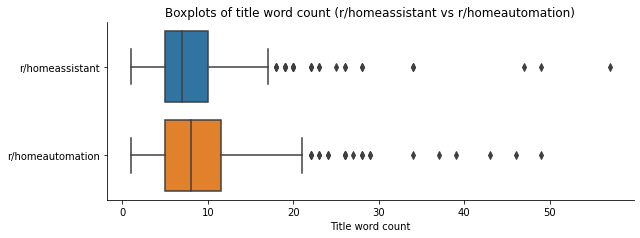

In [59]:
g = sns.catplot(x='title_word_count', y='target', kind='box', data=subreddit_df, height=3, aspect=3.0)
plt.title('Boxplots of title word count (r/homeassistant vs r/homeautomation)')
plt.xlabel('Title word count')
plt.ylabel('')
plt.show()

Boxplot revealed that the median lengths for titles in both subreddits are nearly similar (approximately 7 for r/homeassistant, and 8 for r/homeautomation). Moreover, both medians are within the inter-quartile ranges of the other subreddit, which suggests that there is likely no distinct difference between distributions of title lengths of both subreddits. The longer whiskers (r/homeassistant seems to have a shorter one), as well as the outliers, occurring on the higher end of the *title_word_count* axis also indicate a right skew due to presence of a small proportion of posts with really long titles, existing on both subreddits.

In [60]:
def subplot_histograms(dataframe, subreddit_list, target_col, list_of_titles, fig_size, list_of_xlabels, list_of_ylabels):
    nrows = int(np.ceil(len(subreddit_list)/2)) # Makes sure you have enough rows
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=fig_size) # You'll want to specify your figsize
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    for i, sr_name in enumerate(subreddit_list): # Gives us an index value to get into all our lists
        ax[i].hist(dataframe.loc[dataframe.loc[:,'target']==sr_name, target_col], bins=20)
        ax[i].set_title(list_of_titles[i], fontsize=14)
        ax[i].set_xlabel(list_of_xlabels[i], fontsize=10)
        ax[i].set_ylabel(list_of_ylabels[i], fontsize=10)
        #ax[i].set_ylim(ylimits[i]) # otherwise it would have the .5 segments
        ax[i].axvline(dataframe.loc[dataframe.loc[:,'target']==sr_name, target_col].median(), color='red', linestyle='dashed', linewidth=2, label='Median')
        ax[i].axvline(dataframe.loc[dataframe.loc[:,'target']==sr_name, target_col].mean(), color='green', linestyle='dotted', linewidth=2, label='Mean')
        ax[i].legend()

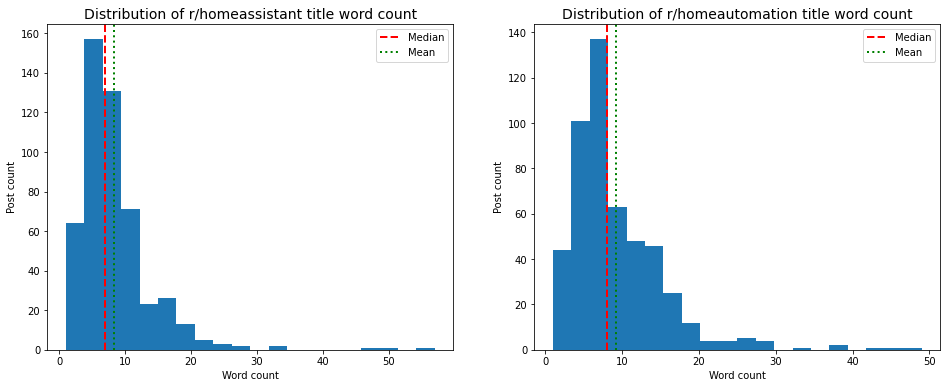

In [61]:
subplot_histograms(subreddit_df, 
                  ['r/homeassistant', 'r/homeautomation'], 
                  'title_word_count', 
                  ['Distribution of r/homeassistant title word count', 'Distribution of r/homeautomation title word count'],
                  (16, 6),
                  ['Word count', 'Word count'],
                  ['Post count', 'Post count'])

Histograms further confirm that the distribution of title word counts are non-normal on both subreddits. With means on the right side of the median values, as well long tails towards towards the higher end of the Word count axis, indicate that both distributions are right-skewed with a few post having long titles.

## Display examples of long titles in both subreddits

Here, we inspect a few of the long titles present in both r/homeassistant and r/homeautomation:

In [62]:
long_home_assistant_titles = list(subreddit_df.loc[(subreddit_df.loc[:,'target']=='r/homeassistant') & (subreddit_df.loc[:,'title_word_count']>20),'title'])
print('\nLong titles from posts in r/homeassistant:')
for long_title in long_home_assistant_titles[:3]:
    print('\n'+long_title)


Long titles from posts in r/homeassistant:

Hey Home Assistant squad! With Black Friday / Cyber Monday sales in full swing, what protocols are your go-to to purchase in 2020?

Crossposting since it’s kind of why we all use Home Assistant. Suddenly, the value of local control dawns on people. (Yes, I know, Nabu Casa experienced issue too)

trying to turn a switch off after its been on for 10 seconds but its not working. Any ideas what wrong with the code it generated.


In [63]:
long_home_automation_titles = list(subreddit_df.loc[(subreddit_df.loc[:,'target']=='r/homeautomation') & (subreddit_df.loc[:,'title_word_count']>22),'title'])
print('\nLong titles from posts in r/homeautomation:')
for long_title in long_home_automation_titles[:3]:
    print('\n'+long_title)


Long titles from posts in r/homeautomation:

[Beginner] I'm looking to spice up Christmas decorations with Home Automation from a Google Nest. What are my options? I want Google commands for lights on and lights off. If I get non-intelligent strings of lights, what can I do with minimal budget?

“Should our homes have an airplane mode?” the RAM House, a fully-equipped smart home that alternatively doubles as a refuge from the ubiquitous technology of today.

Anyone affected by this? I was going to buy one but if they are uniquely tied to Amazon for connection I might look for another company.


As observed above, some users prefer to commence with a series a questions within the title itself, which leads to them having high word count.

## Analyse post word count

We also analyse the word count of the main posts for both subreddits, so as to observe if there are any differences in prose length:

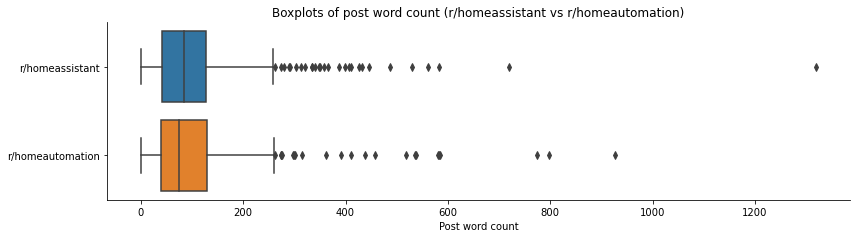

In [64]:
g = sns.catplot(x='post_word_count', y='target', kind='box', data=subreddit_df, height=3, aspect=4.0)
plt.title('Boxplots of post word count (r/homeassistant vs r/homeautomation)')
plt.xlabel('Post word count')
plt.ylabel('')
plt.show()

The median word count of both subreddits still fall within the inter-quartile ranges of each other, so the difference in distributions of post word count is rather insignificant. Again, both subreddits have outliers occurring only on the higher end of the word count range, with r/homeassistant having slightly more outlier posts.

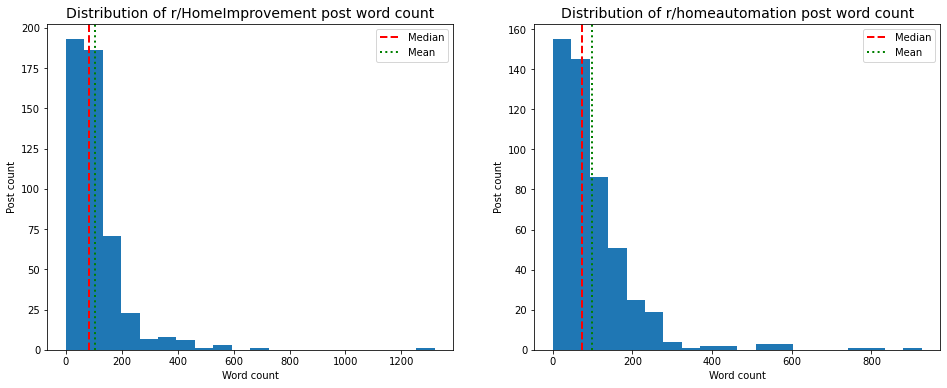

In [65]:
subplot_histograms(subreddit_df, 
                  ['r/homeassistant', 'r/homeautomation'], 
                  'post_word_count', 
                  ['Distribution of r/HomeImprovement post word count', 'Distribution of r/homeautomation post word count'],
                  (16, 6),
                  ['Word count', 'Word count'],
                  ['Post count', 'Post count'])

Histogram plots for post word count indicates trends that are similar to the title word count. Distributions here are right-skewed, due to presence of a small proportion of really long posts. Mode for both subreddits distribution lie within the *0-50* bin, suggesting that short posts are mostly preferred in both sides.

## Analyse frequency used words

We could project frequently occurring words in a form of a simple wordcloud, where the size of words appearing in it would give a sense of the frequency of its occurrence, i.e. the larger the word, the more times it has appeared within a given text.

While wordclouds are not a formal way to perform statistical analysis, they provide a quick means to visualize the most frequently used terms within both subreddits, and any difference could be quickly observed.

### Create functions to generate and plot the wordclouds

In [66]:
# function to plot the cloud
def plot_cloud(wordcloud, subreddit_name):
    plt.figure(figsize=(14, 10))
    plt.title('Wordcloud for {}'.format(subreddit_name))
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off");

In [67]:
# function to generate word cloud
def generate_cloud(input_text, color_map, custom_stopwords):
    wc = WordCloud(
        width = 3000, 
        height = 2000, 
        random_state=42, 
        background_color='white', 
        colormap=color_map, 
        collocations=False, 
        regexp=r'\S+',
        stopwords = custom_stopwords).generate(input_text)
    return wc

### Combine all texts from a subreddit into a single text

We concatenate all the text values in `full_text_no_punctuation` to form a single text input for the word cloud generation:

In [68]:
#HomeImprovement
#homeassistant
assist_full_text_list = list(subreddit_df.loc[subreddit_df.loc[:,'target']=='r/homeassistant','full_text_no_punctuation'])
assist_big_text = ' '.join(assist_full_text_list)

auto_full_text_list = list(subreddit_df.loc[subreddit_df.loc[:,'target']=='r/homeautomation','full_text_no_punctuation'])
auto_big_text = ' '.join(auto_full_text_list)

### Construct a custom stopword list

We augment the stop-words with a few more words that are expected to appear frequently in both subreddits, which would not contribute to the effort of attempting to differentiate between the 2 subreddits:

In [69]:
# nltk stopwords
nltk_stopwords = set(sw.words('english'))

# sklearn stopwords
sklearn_stopwords = list(CountVectorizer(stop_words = 'english').get_stop_words())

# wordcloud stopwords
wordcloud_stopwords = set(STOPWORDS)
#improvement
wordcloud_stopwords.update(["home", "assistant", "automation"])

print('nltk stopword list-size: {}'.format(len(nltk_stopwords)))
print('sklearn stopword list-size: {}'.format(len(sklearn_stopwords)))
print('wordcloud stopword list-size: {}'.format(len(wordcloud_stopwords)))

custom_stopwords = set(list(nltk_stopwords) + sklearn_stopwords + list(wordcloud_stopwords))
#custom_stopwords.update(["I'm", "thank", "I’m", "I’ve", "i’m", "it's", "house"])
print('custom stopword list-size: {}'.format(len(custom_stopwords)))

nltk stopword list-size: 179
sklearn stopword list-size: 318
wordcloud stopword list-size: 195
custom stopword list-size: 417


### Generate wordclouds for both subreddits for comparison

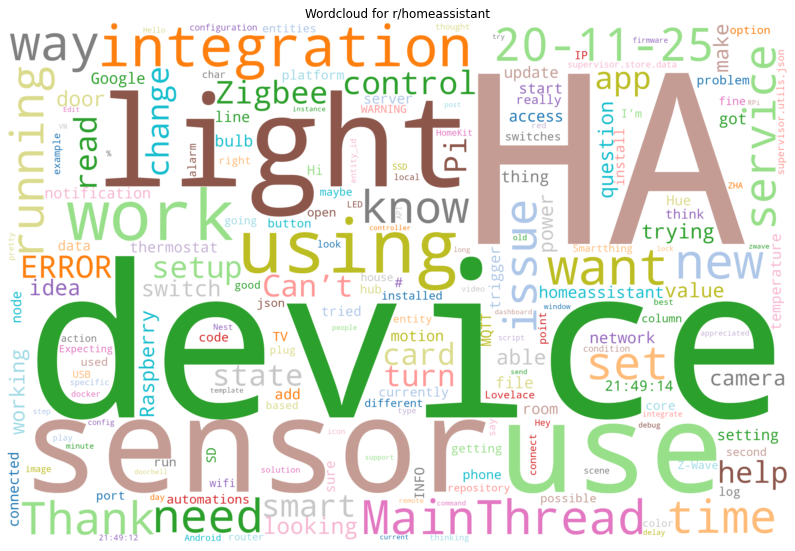

In [70]:
# Create word cloud for r/HomeImprovement
plot_cloud(generate_cloud(assist_big_text, 'tab20', custom_stopwords), 'r/homeassistant')

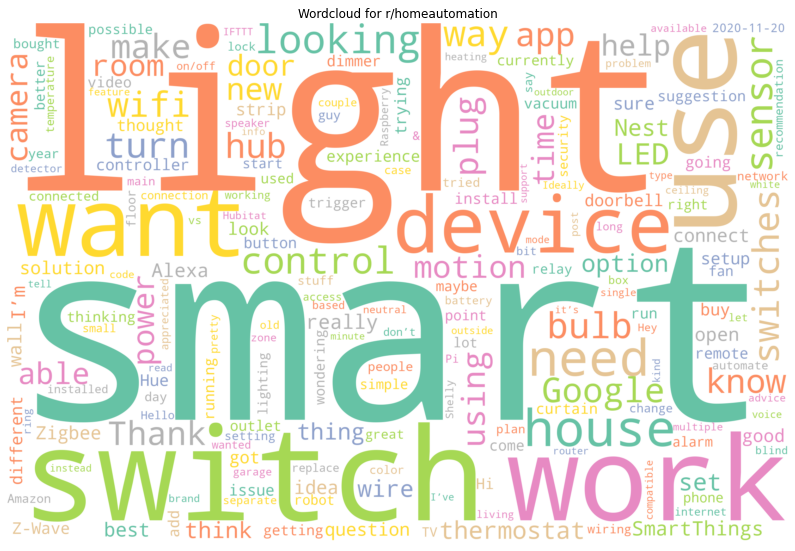

In [71]:
# Create word cloud for r/homeautomation
plot_cloud(generate_cloud(auto_big_text, 'Set2', custom_stopwords), 'r/homeautomation')

The 2 word clouds have revealed some interesting observations:

- For r/homeassistant, *integration*, *light*, *device*, *sensor* and "mainthread* and *error* occur frequently, suggesting that many discussions are centered around issues with customizing and creating home-assistant devices from individual components. In fact, the brand *Zigbee* refers to a line of electronic modules that provide low-powered, wireless connectivity for electronic devices, while *raspberry* (a.k.a Raspberry Pi), a brand of small, single-board computers that are popular with hobby electronic enthusiasts.


- For r/homeautomation, *light*, *smart*, *switch*, *sensor*, *control* and *device* occur frequently, suggesting that discussions in this subreddit revolve around electrical and electronic fixtures that are smart-home enabled, which would allow remote monitoring and manipulation of its attributes. Brands like *Google* and *Alexa* (from Amazon) appear here, owing to the popular competing brands in the market for smart-home devices.

## Analyse word frequency

In [72]:
# create helper function to compute the most frequent terms
def get_top_word_freq(subreddit_name, top_threshold):
    text_series = subreddit_df.loc[subreddit_df.loc[:,'target']==subreddit_name,'full_text_no_punctuation']

    word_list = [word.lower() for text in text_series for word in re.findall(r'\S+', text)]

    word_list_stopped = [w for w in word_list if w not in custom_stopwords]

    word_freq_df = pd.DataFrame({'word': word_list_stopped}).value_counts().rename_axis('word').reset_index(name='counts')

    return word_freq_df.head(top_threshold)

In [73]:
# create helper function to plot horizontal barchart
def plot_barchart(data, subreddit_name):
    plt.figure(figsize=(10, 8))
    plt.title('Top 20 most frequently occurring terms in {}'.format(subreddit_name))
    g = sns.barplot(data=data, y='word', x='counts')
    plt.ylabel('')
    plt.show()
    #plt.savefig('./images/top_20_words_home_improvement.jpg')
    #home_improvement_top_words_df

    #fig = g.get_figure()
    #fig.savefig('./images/top_20_words_home_improvement.jpg')

In [74]:
def plot_barcharts(data_list, subreddit_name_list):
    fig, ax = plt.subplots(1, 2, figsize=(16,8))
    for index, data in enumerate(data_list):
        sns.barplot(data=data, y='word', x='counts', ax=ax[index])
        ax[index].set_ylabel('')
        ax[index].set_title('Top 20 most frequently occurring terms in {}'.format(subreddit_name_list[index]))
    plt.show()

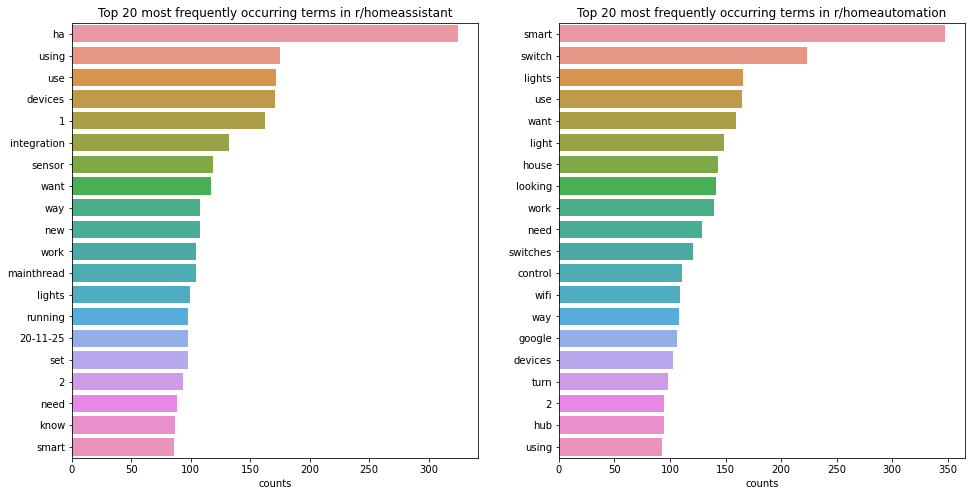

In [75]:
#plot_barchart(get_top_word_freq('r/homeassistant', 20), 'r/homeassistant')
#plot_barchart(get_top_word_freq('r/homeautomation', 20), 'r/homeautomation')
plot_barcharts([get_top_word_freq('r/homeassistant', 20),
                get_top_word_freq('r/homeautomation', 20)],
               ['r/homeassistant','r/homeautomation'])

Topping the list of most frequently used terms in r/homeassistant is *ha*, an abbreviation for *home assistant* that users in this subreddit constantly use to refer to the home-assistant product in question. Other nouns like *sensor* suggests that uses are seeking discussion or advice on certain components on a device. *Integration* indicates that users might be attempting to introduce their home-assistant product into an existing system, such as a home network. The term *mainthread* is typically used in programmatic code, also indicating that users in r/homeassistant maybe doing a lot of low-level tinkering with their devices.

As for r/homeautomation, we have frequently occurring nouns like *switch*, *lights* (including variant *light*), *wifi*, *devices*, and even *Google* as a brand name. Adjective *smart* suggest that majority of posts in this subreddit is seeking advice or discussion on smart devices, which can be connected to a network (such as the Web) for remote access. Unlike r/homeassistant, users in r/homeautomation discuss more about devices that are ready to use with minimal configuration.

Despite such difference, both subreddits also have similar words in their word clouds and top 20 tables. Words such as *smart*, *lights*, *devices*, *work* and *want*, all generally indicate that both communities are congregating in their respective subreddits to discuss about their intention to tweak or resolve functionality issues that are centering around their smart home appliances.

# Save data to CSV file

We save the cleaned dataset to CSV file for later use in *Preprocessing & Modeling* phase:

In [76]:
subreddit_df.to_csv(join(data_subfolder, 'subreddits_cleaned.csv'), index=False)

The cleaned set of data can be used in the next notebook for preprocessing and model creation.